In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [6]:
TRAIN_PATH = "../data/train.csv"
TEST_PATH = '../data/test.csv'
Full_train = pd.read_csv(TRAIN_PATH,index_col='Id')
Full_test = pd.read_csv(TEST_PATH)
Full_train.dropna(axis=0,subset=['SalePrice'], inplace=True)
y_full = Full_train.SalePrice
X_full = Full_train.drop(axis=1, columns=['SalePrice'])

In [7]:
Full_train = Full_train.rename(columns={'SalePrice' : 'price'})
Full_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,price
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [8]:
#columns_to_drop = ['MoSold','YrSold'] # these columns could be cause of data leakage, it is better to drop them
X_full.drop(columns_to_drop, axis=1, inplace=True)

In [9]:
numeric_col = list((X_full.select_dtypes(exclude='object')).columns)
string_col = list((X_full.select_dtypes(include='object')).columns)
low_categorical_col = [col for col in X_full.columns
                  if X_full[col].dtype == 'object' and X_full[col].nunique() <10]

# Explore data
## column dtypes

In [10]:
# to see dtypes of all columns, we need change max_rows
pd.set_option('display.max_rows', 80)
Full_train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object
HeatingQC         object


### find all nans
Probably, the only missed value is 'Electricial'(or maybe there was no electricity in this house?), in others cases nan is another category

In [11]:
Full_train.isna().sum()[Full_train.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [12]:
Full_train[numeric_col].isna().sum()[Full_train[numeric_col].isna().sum() > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

LotFrontage is linear feet of street connected to property,
MasVnrArea is Masonry veneer area in square feet. So, it can be NaN


GarageYrBlt can be nan if no garage exist

In [13]:
missed_numeric_values = Full_train[numeric_col].isna().sum()[Full_train[numeric_col].isna().sum() > 0].index
print(missed_numeric_values)

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')


## numeric data
correlation between numeric cols

In [15]:
full_x_corr = Full_train.corr()

<AxesSubplot:>

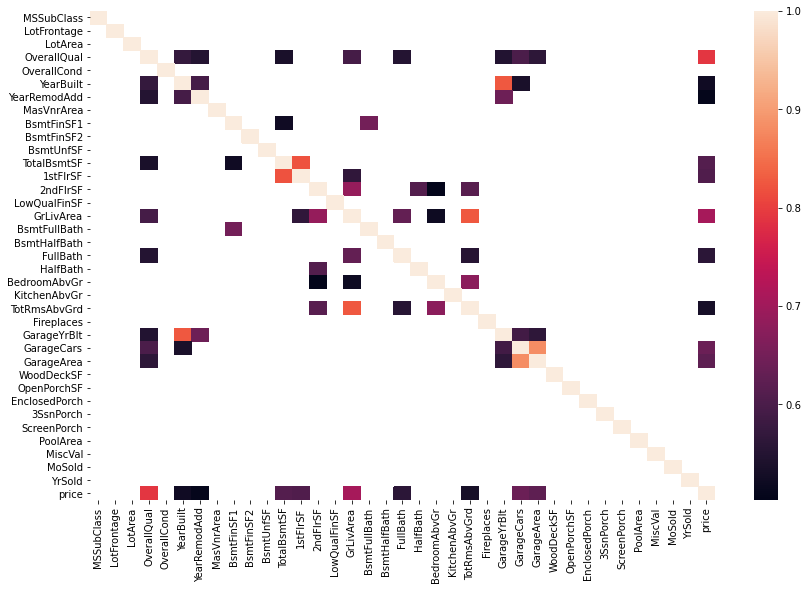

In [17]:
plt.figure(figsize=(14,9))
sns.heatmap(full_x_corr, mask=abs(full_x_corr) < 0.5, xticklabels=True, yticklabels=True)

These features has high correlation with price

In [35]:
price_corr = full_x_corr.loc['price']
price_corr = price_corr.iloc[:-1] # last row is correlation with itself, so it will be dropped

In [37]:
price_corr.loc[abs(price_corr) >= 0.25]

LotFrontage     0.351799
LotArea         0.263843
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477493
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
HalfBath        0.284108
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.486362
GarageCars      0.640409
GarageArea      0.623431
WoodDeckSF      0.324413
OpenPorchSF     0.315856
Name: price, dtype: float64

In [38]:
strong_corr = price_corr.loc[abs(price_corr) >= 0.75]
strong_corr

OverallQual    0.790982
Name: price, dtype: float64

In [45]:
moderate_corr = price_corr.loc[(abs(price_corr) >= 0.5) & ~(price_corr.index.isin(strong_corr.index))]
moderate_corr

YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
Name: price, dtype: float64

These features have high correlation of features that influence the price

maybe they should be categorical

In [46]:
from_num_to_cat = ['GarageCars', 'GarageYrBlt', 'YearBuilt', 'BedroomAbvGr', '2ndFlrSF']

It was tested, without rows containing NaN, with 2 last features model performs slight better.(but a bit of worse comparing to using all rows without last 2 columns). It is possible that without dropping NaNs (imputing them) model could perforrm better ( need teest id)

# GarageCars

since GarageArea contains information on how many cars can fit in the garage, needed only one of them: either GarageCars or GarageArea

## GarageYrBlt
trying different things it was concluded, that there is no linear relationship between garageYrBuilt and price. But, perhaps, there *is* relationship, see the graphics below

### Bin GarageYrBlt

In [99]:
def find_best_bins_split(k, feature):
    best_corr = 0
    best_split = 0
    for k_bins in range(1,k):
        bins = np.linspace(Full_train[feature].min(), Full_train[feature].max(), k_bins)
        years = pd.cut(Full_train[feature], bins=bins, include_lowest=True) # splitting original column on k bins and creating categorical variable
        le = LabelEncoder()
        le.fit(years)
        encoded = pd.Series(le.transform(years)) # encoding categorical variable
        y = Full_train['price'].reset_index().price 
        corr = encoded.to_frame().join(y).corr()['price'].iloc[0]
        if abs(corr) > best_corr:
            best_corr = corr
            best_split = k_bins
    return best_split, best_corr

In [63]:
Full_train['GarageYrBlt'].nunique()

97

In [64]:
split, corr_coeff = find_best_bins_split(97,'GarageYrBlt')

In [79]:
corr_coeff

0.3847687969006023

In [66]:
split

95

The best possible split is using all (almost) columns, hence there is no use in equall split.

#### replacing Year of build on Age of garage

In [67]:
Full_train['GarageYrBlt']

Id
1       2003.0
2       1976.0
3       2001.0
4       1998.0
5       2000.0
         ...  
1456    1999.0
1457    1978.0
1458    1941.0
1459    1950.0
1460    1965.0
Name: GarageYrBlt, Length: 1460, dtype: float64

In [70]:
age_of_garage = Full_train['YrSold'] - Full_train['GarageYrBlt']

In [81]:
age_of_garage.isna().sum()

81

In [71]:
age_of_garage.nunique()

101

In [84]:
age_of_garage.replace(np.nan, 0).corr(y_full)

-0.3898082004901332

In [78]:
age_of_garage.corr(y_full)

-0.48706858845296663

In [96]:
data = age_of_garage.to_frame().join(y_full)
data.columns = ['age', 'price']

### Perhaps, there is non-linear relationship between garage and price

<AxesSubplot:xlabel='age'>

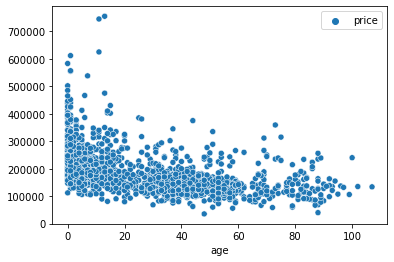

In [98]:
sns.scatterplot(data=data.set_index('age'))

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

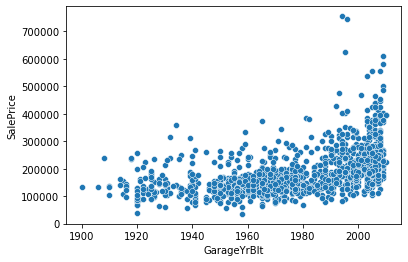

In [95]:
sns.scatterplot(x=Full_train['GarageYrBlt'], y=y_full)

## YearBuilt

In [24]:
feature = 'YearBuilt'
bins = np.linspace(Full_train[feature].min(), Full_train[feature].max(), 13)
years = pd.cut(Full_train[feature], bins=bins, include_lowest=True)

In [26]:
le = LabelEncoder()
le.fit(years)

LabelEncoder()

In [27]:
encoded = le.transform(years)

In [28]:
pd.Series(encoded).to_frame().join(y).corr()

,0,price
0,1.000000,0.511377
price,0.511377,1.000000


I do not know how exactly I should bin the YearBuilt for best result, but I can say this feature is worth further examination

In [100]:
Full_train['YearBuilt'].nunique()

112

In [101]:
find_best_bins_split(112,'YearBuilt')

(111, 0.5352166886201967)

### Age of house

In [102]:
age_house = Full_train['YrSold'] - Full_train['YearBuilt']

In [106]:
age_house.corr(y_full)

-0.523350417546816

In [107]:
Full_train['YearBuilt'].corr(y_full)

0.5228973328794969

<AxesSubplot:ylabel='SalePrice'>

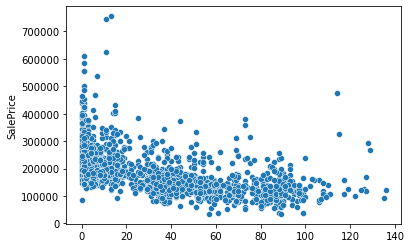

In [108]:
sns.scatterplot(x=age_house, y=y_full)

## BedroomAbvGr

In [110]:
feature  = 'BedroomAbvGr'
Full_train[feature]

Id
1       3
2       3
3       3
4       3
5       4
       ..
1456    3
1457    3
1458    4
1459    2
1460    3
Name: BedroomAbvGr, Length: 1460, dtype: int64

<AxesSubplot:xlabel='BedroomAbvGr', ylabel='SalePrice'>

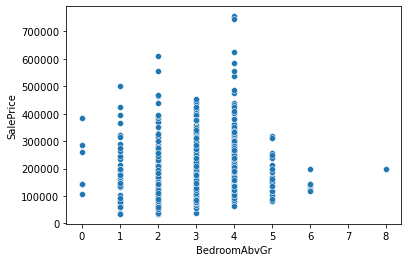

In [111]:
sns.scatterplot(x=Full_train[feature], y=y_full)

## 2ndFlrSF

In [112]:
feature = '2ndFlrSF'
Full_train[feature]

Id
1        854
2          0
3        866
4        756
5       1053
        ... 
1456     694
1457       0
1458    1152
1459       0
1460       0
Name: 2ndFlrSF, Length: 1460, dtype: int64

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

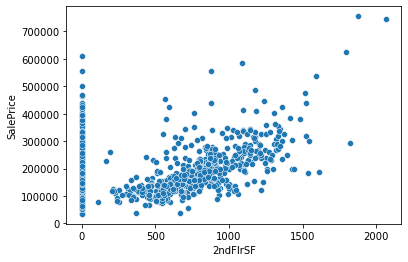

In [115]:
sns.scatterplot(x=Full_train[feature], y=y_full)

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

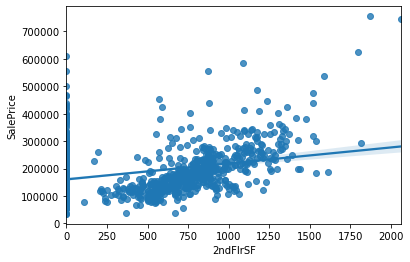

In [127]:
sns.regplot(x=Full_train[feature], y=y_full)

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

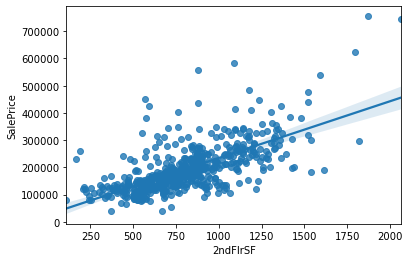

In [125]:
flr2_no0 = Full_train[feature].loc[Full_train[feature] != 0]
sns.regplot(x=flr2_no0, y=y_full.loc[flr2_no0.index])

In [126]:
flr2_no0.corr(y_full.loc[flr2_no0.index])

0.6733048324568377

If there is no 2 floor, then price depend on other features. But if the second floor exists, then there is some kind of linear relationship

# Handling missed value
But do I really need to handle it? Will correlation be increased if these features didnot have NaN, or, rather, was categorical

In [42]:
missed_num_df = Full_train[missed_numeric_values].copy()

In [43]:
missed_num_df.isna().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

GarageYrBlt - I will not use this feature, no need to do something with this column

In [47]:
missed_num_df.drop(columns='GarageYrBlt', inplace=True)

In [48]:
missed_num_df.corrwith(Full_train['price'])

LotFrontage    0.351799
MasVnrArea     0.477493
dtype: float64

In [49]:
missed_num_df

,LotFrontage,MasVnrArea
Id,,
1,65.0,196.0
2,80.0,0.0
3,68.0,162.0
4,60.0,0.0
5,84.0,350.0
...,...,...
1456,62.0,0.0
1457,85.0,119.0
1458,66.0,0.0


In [50]:
missed_num_df['MasVnrArea'].value_counts()

0.0      861
108.0      8
72.0       8
180.0      8
16.0       7
        ... 
31.0       1
366.0      1
528.0      1
894.0      1
415.0      1
Name: MasVnrArea, Length: 327, dtype: int64

In [51]:
861/1460

0.5897260273972603

There is about 861 zeros, more that 50% of dataset contains non-meaningful information, and there is no even weak correlation, I doubt I can do something to increase correlation, so I drop it either

In [52]:
missed_num_df.drop(columns='MasVnrArea', inplace=True)

LotFrontage - I doubt I even need this feature ( Linear feet of street connected to property), so I dropping this as well

as result - I do not use columns with missed values, so I do not need to somehow handle it

### Finding best features
checking correlation and p-value for numeric features

In [94]:
F_P = {}
for feature in numeric_col:
    y = pd.Series(Full_train['price'], index=Full_train[feature].dropna().index)
    pearson_coef, p_value = stats.pearsonr(Full_train[feature].dropna(),y)
    #if (abs(pearson_coef) > 0.5):
    F_P[feature] = (pearson_coef, p_value)
    #print('Feature:',feature)
    #print('The correlation coefficient is:', pearson_coef, 'the p-value is:', p_value)
for k in F_P:
    print(k, F_P[k])

MSSubClass (-0.0842841351265952, 0.0012664716847503312)
LotFrontage (0.35179909657067787, 2.6024418123943414e-36)
LotArea (0.2638433538714057, 1.1231391549193063e-24)
OverallQual (0.7909816005838048, 2.185675268e-313)
OverallCond (-0.07785589404867801, 0.0029123512679174826)
YearBuilt (0.5228973328794968, 2.9902290990158995e-103)
YearRemodAdd (0.5071009671113862, 3.1649482419200737e-96)
MasVnrArea (0.47749304709571555, 1.458508642588133e-83)
BsmtFinSF1 (0.3864198062421533, 3.3941098292907553e-53)
BsmtFinSF2 (-0.011378121450215144, 0.663998650834577)
BsmtUnfSF (0.2144791055469689, 1.1829757963600795e-16)
TotalBsmtSF (0.6135805515591954, 9.484229391507914e-152)
1stFlrSF (0.6058521846919146, 5.394710618971284e-147)
2ndFlrSF (0.31933380283206786, 5.764335119183061e-36)
LowQualFinSF (-0.02560613000067956, 0.32820730984074886)
GrLivArea (0.708624477612652, 4.518033646780971e-223)
BsmtFullBath (0.22712223313149424, 1.550344137214128e-18)
BsmtHalfBath (-0.016844154297359012, 0.5201536357280931

In [96]:
for k in F_P:
    if F_P[k][0] > 0.5:
        print(k, F_P[k])

OverallQual (0.7909816005838048, 2.185675268e-313)
YearBuilt (0.5228973328794968, 2.9902290990158995e-103)
YearRemodAdd (0.5071009671113862, 3.1649482419200737e-96)
TotalBsmtSF (0.6135805515591954, 9.484229391507914e-152)
1stFlrSF (0.6058521846919146, 5.394710618971284e-147)
GrLivArea (0.708624477612652, 4.518033646780971e-223)
FullBath (0.560663762748446, 1.2364700667605807e-121)
TotRmsAbvGrd (0.5337231555820281, 2.772280932958432e-108)
GarageCars (0.640409197258352, 2.498644167178942e-169)
GarageArea (0.6234314389183616, 5.2650381679802e-158)


In [98]:
for k in F_P:
    if F_P[k][1] < 0.05:
        print(k, F_P[k])

MSSubClass (-0.0842841351265952, 0.0012664716847503312)
LotFrontage (0.35179909657067787, 2.6024418123943414e-36)
LotArea (0.2638433538714057, 1.1231391549193063e-24)
OverallQual (0.7909816005838048, 2.185675268e-313)
OverallCond (-0.07785589404867801, 0.0029123512679174826)
YearBuilt (0.5228973328794968, 2.9902290990158995e-103)
YearRemodAdd (0.5071009671113862, 3.1649482419200737e-96)
MasVnrArea (0.47749304709571555, 1.458508642588133e-83)
BsmtFinSF1 (0.3864198062421533, 3.3941098292907553e-53)
BsmtUnfSF (0.2144791055469689, 1.1829757963600795e-16)
TotalBsmtSF (0.6135805515591954, 9.484229391507914e-152)
1stFlrSF (0.6058521846919146, 5.394710618971284e-147)
2ndFlrSF (0.31933380283206786, 5.764335119183061e-36)
GrLivArea (0.708624477612652, 4.518033646780971e-223)
BsmtFullBath (0.22712223313149424, 1.550344137214128e-18)
FullBath (0.560663762748446, 1.2364700667605807e-121)
HalfBath (0.28410767559478256, 1.6504733955727557e-28)
BedroomAbvGr (0.16821315430073996, 9.927497326187329e-11)

We can see, that the only meaningfull values are same that in good_correlation. But there is some features that wee can add to see how it will influence on SalesPrice.(Having fireplace, Pool, 2nd floor etc.)

#### Creating new features
We can try to create new features and see, how it will work out

In [43]:
porch = ['EnclosedPorch', 'OpenPorchSF','3SsnPorch','ScreenPorch']
BSM_bath = ['BsmtFullBath', 'BsmtHalfBath']
bath = ['FullBath', 'HalfBath']

In [44]:
for col in Full_train.columns:
    if 'area' in str.lower(col):
        print(col)

LotArea
MasVnrArea
GrLivArea
GarageArea
PoolArea


In [45]:
areas = ['LotArea', 'MasVnrArea', 'GrLivArea','GarageArea','PoolArea']

In [46]:
selected_features_df = Full_train[price_corr.index].copy(deep=True)
selected_features_df['Has_pool'] = Full_train['PoolArea'] > 0
selected_features_df['Has_fireplace'] = Full_train['Fireplaces'] > 0
selected_features_df['Total_porch'] = Full_train[porch].sum(axis=1)
selected_features_df['Total_BSM_bath'] = Full_train[BSM_bath].sum(axis=1)
selected_features_df['Has_2flr'] = Full_train['2ndFlrSF'] > 0
selected_features_df['Total_Bath'] = Full_train[bath].sum(axis=1)
selected_features_df['Has_garage'] = Full_train['GarageArea'] > 0
selected_features_df['Total_area'] = Full_train[areas].sum(axis=1)
selected_features_df

NameError: name 'price_corr' is not defined

In [ ]:
bools = ['Has_pool', 'Has_fireplace', 'Has_2flr', 'Has_garage']

In [ ]:
selected_features_df[bools] = selected_features_df[bools].astype(int)
selected_features_df.dtypes

In [ ]:
new_added_cols = [col for col in selected_features_df.columns
                 if col not in Full_train.columns]
print(new_added_cols)

Now lets repeat process with correaltion and p_value

In [ ]:
for feature in new_added_cols:
    pearson_coef, p_value = stats.pearsonr(selected_features_df[feature],y_full)
    #if (abs(pearson_coef) > 0.5):
    print('Feature:',feature)
    print('The correlation coefficient is:', pearson_coef, 'the p-value is:', p_value)

Total_Bath is new feature that worth attention
(probably it is not linear)

In [ ]:
sns.boxplot(x='Total_Bath', y='SalePrice', data=selected_features_df)

In [ ]:
sns.regplot(x='Total_Bath', y='SalePrice', data=selected_features_df, order=3)

In [ ]:
features_num_good_corr = list(price_corr.sort_values(ascending=False).index)
features_num_good_corr += ['Total_Bath']
features_num_good_corr = features_num_good_corr[1:] # remove SalePrice
print(features_num_good_corr[1:])

In [ ]:
price_corr.sort_values(ascending=False)

## low_cardinality features

In [ ]:
low_cardinality_df = Full_train[low_categorical_col]
low_cardinality_df

In [ ]:
low_cardinality_df.isna().sum()[low_cardinality_df.isna().sum() > 0]

I will return to handling nans later, for now I will drop it

In [ ]:
low_cardinality_cols_with_nans = list(low_cardinality_df.isna().sum()[low_cardinality_df.isna().sum() > 0].index)

In [ ]:
without_nan_df = low_cardinality_df.dropna(axis=1)
without_nan_df

In [ ]:
without_nan_df.describe(include=['object'])

In [ ]:
without_nan_df = without_nan_df.join(y_full)

### Find significant categorical features
but first declare some valuable functions

# Do I need it?

In [ ]:
def get_dic_name_need_change():
    dic = {}
    y = find_n_percent_of_data(Full_train.shape[0], 5)
    for col_info in cols_with_big_F_score+cols_with_low_F_score:
        col_name = col_info[0]
        values_less_then_y = Full_train[col_name].value_counts() < y    
        values = []
        for i in range(1,len(values_less_then_y)):
            group_value_counts = values_less_then_y.iloc[-i]
            if group_value_counts:
                group_value = values_less_then_y.index[-i]
                values.append(group_value)

        if len(values) > 0:
            dic[values_less_then_y.name] = values
    return dic

Func, that score ANOVA for specific dataframe

In [ ]:
def score_ANOVA(data):
    '''
    score ANOVA for all columns in data. Last column must be SalePrice - this is the exit point.
    return 3 lists:
    cols_that_need_further_investigation - ANOVA <=10;
    cols_with_big_F_score - ANOVA > 50
    cols_with_low_F_score - ANOVA <= 50
    '''
    cols_that_need_further_investigation = []
    cols_with_big_F_score = []
    cols_with_low_F_score = []
    
    for col in data.columns:
        if col == 'SalePrice':
            break
        df = data[[col,'SalePrice']]
        grouped_col_price = df.groupby([col],as_index=False)
        uniques_col_values = df[col].unique()
        if len(uniques_col_values) == 1:
            print(f'cols has only one value! ({col})')
            continue
        args = [grouped_col_price.get_group(uniques_col_values[i])['SalePrice'] for i in range(len(uniques_col_values))]
        f_val, p_val = stats.f_oneway(*args)
        #print('column name: ',col)
        #print( "ANOVA results: F=", f_val, ", P =", p_val)  
        if (f_val <=10):
            cols_that_need_further_investigation.append([col, f_val, p_val])
        elif (f_val > 50):
            cols_with_big_F_score.append([col, f_val, p_val])
        else:
            cols_with_low_F_score.append([col, f_val, p_val])
    cols_that_need_further_investigation.sort(key=lambda x:x[1], reverse=True)
    cols_with_big_F_score.sort(key=lambda x:x[1], reverse=True)
    cols_with_low_F_score.sort(key=lambda x:x[1], reverse=True)
    return cols_that_need_further_investigation, cols_with_big_F_score, cols_with_low_F_score

Func that creating boxplot on giving data and columns

In [ ]:
# column_info is list contains [col_name, f_val, p_val]
def make_boxplots(column_info, data, subplot_size=[4,4,1]):
    r = subplot_size[0]
    c = subplot_size[1]
    i = subplot_size[2]
    plt.figure(figsize=(20,20))
    for col in column_info:
        #plt.figure()
        plt.subplot(r,c,i)
        i+=1
        sns.boxplot(data=data, y=y_full, x=col[0])

In [ ]:
def find_n_percent_of_data(total_rows, n=5):
    '''
    total_rows => 100%
     y => n%
     we know n(5%, for example), so we find y on this formula:
     y = n*total_rows/100
    ''' 
    return n * total_rows / 100

Dist plot will be plotted with red line, where red line shows 5% of data

In [ ]:
def make_dist(data, col_info_list):
    y = find_n_percent_of_data(data.shape[0],5)
    i = 1
    plt.figure(figsize=(20,20))
    for col_info in col_info_list:
        col_name = col_info[0]
        #plt.figure()
        plt.subplot(4,5,i)
        i += 1
        sns.histplot(data[col_name])
        plt.xticks(rotation=45)
        plt.axhline(y,color='r')

### applying ANOVA method

In [ ]:
cols_that_need_further_investigation, cols_with_big_F_score, cols_with_low_F_score = score_ANOVA(without_nan_df)

In [ ]:
cols_that_need_further_investigation

In [ ]:
make_boxplots(cols_that_need_further_investigation,data=without_nan_df)

It is clearly seen that these columns will be bad at predicting house price

In [ ]:
all_rows = Full_train.shape[0] 
for col_info in cols_that_need_further_investigation:
    # get value_counts in percentage
    col_name = col_info[0]
    print(Full_train[col_name].value_counts() / all_rows * 100)

As we can see, very big percentage of data has one value, therefore these variables are no use

 #### Double check ExterCond and LotConfig
These groups doe not have enough samples for  different groups, so they are no use, but it is better to double check ExterCond and LotConfig, just to be sure

##### ExterCond

In [ ]:
invest_df = Full_train[['ExterCond', 'LotConfig', 'SalePrice']]
group = invest_df.groupby(['ExterCond', 'LotConfig'],as_index=False).mean()
pivot = group.pivot(columns='ExterCond', index='LotConfig')
pivot
#f_score, p_val = stats.f_oneway()

In [ ]:
sns.heatmap(pivot.fillna(0))

Fa, Gd, Ta - There is no big difference between Fa and Gd. However, Ta is valued more. I believe there is no significant statisctical difference, So I will not use this column

In [ ]:
invest_df['ExterCond'].value_counts()

It is clear, that Po and Ex are outliers

In [ ]:
group = invest_df.groupby(['ExterCond'],as_index=False)
group.mean()

In [ ]:
stats.f_oneway(group.get_group('Ex')['SalePrice'], group.get_group('Fa')['SalePrice'], group.get_group('Gd')['SalePrice'])

Comparing previous result (ANOVA results: F= 8.798714214177485 , P = 5.106680608671862e-07), this is barely better. I decide to not use this columns as predicator

#### LotConfig

In [ ]:
invest_df['LotConfig'].value_counts()

In [ ]:
group = invest_df.groupby(['LotConfig'],as_index=False)
group.mean()

In [ ]:
stats.f_oneway(group.get_group('Corner')['SalePrice'], group.get_group('Inside')['SalePrice'], group.get_group('CulDSac')['SalePrice'])

Comparing to the previous result (ANOVA results: F= 7.809954123467792 , P = 3.163167473604189e-06), thia ia barely better. However, it is not good enougfh, So, there is no need in picking this column

### Checking cols with good enough F_value

In [ ]:
cols_with_big_F_score

In [ ]:
make_boxplots(cols_with_big_F_score, without_nan_df)

In [ ]:
without_nan_df['HeatingQC'].value_counts()

These columns are probably very good predicators, but need to pay attention HeatingQC: It is only one example of Po! It is not enough

In [ ]:
cols_with_big_F_score

In [ ]:
cols_with_big_F_score

In [ ]:
make_dist(without_nan_df,cols_with_big_F_score)

In [ ]:
cols_with_low_F_score

In [ ]:
make_boxplots(cols_with_low_F_score, without_nan_df)

In [ ]:
make_dist(without_nan_df,cols_with_low_F_score)

In [ ]:
for col_info in cols_with_big_F_score+cols_with_low_F_score:
    # get value_counts in percentage
    col_name = col_info[0]
    print(without_nan_df[col_name].value_counts() / len(without_nan_df) * 100)
    print()

CentralAir Has good F_score, but more then 90% of data contains same value. Does the house price really differ from this variable?
(also need to check SaleCondition(80%), MSZoning(78%),PavedDrive(91%), SaleType(86%), RoofStyle(78%), BldgType(83%), LandContour(89%))

In [ ]:
cols_to_investigate = ['CentralAir', 'SaleCondition','MSZoning','PavedDrive','SaleType','RoofStyle','BldgType','LandContour']

In [ ]:
invest_df = Full_train[cols_to_investigate+['SalePrice']]
invest_df

In [ ]:
group = invest_df.groupby(['CentralAir'], as_index=False).mean()
group.head()

We can conclude, that price have big differnece depend on CentralAir!

In [ ]:
for col in cols_to_investigate:
    group = invest_df.groupby([col], as_index=False).mean()
    print(group.head())
    print()

We can conclude, that different groups have different price, so these are probably good features

also, we can get dic with column names and column values, that contains less then 5% of data

In [ ]:
dic = get_dic_name_need_change()
dic

I need to be accurate with columns that listed above, they have values less than 5% of the entire column

In [ ]:
features_cat_no_nan_very_good = [col[0] for col in cols_with_big_F_score]
print(features_cat_no_nan_very_good)

In [ ]:
cols_with_big_F_score

In [ ]:
features_cat_no_nan_maybe_good = [col[0] for col in cols_with_low_F_score]
print(features_cat_no_nan_maybe_good)

In [ ]:
cols_with_low_F_score

### Handling cat features contains NaN

In [ ]:
df_with_nan = Full_train[low_cardinality_cols_with_nans].copy(deep=True)
df_with_nan = df_with_nan.join(y_full)
df_with_nan

In [ ]:
df_with_nan.isna().sum()[df_with_nan.isna().sum() > 0]

In [ ]:
Full_train['PoolArea'].value_counts()

It seems that pool features are zero or Nan if No Pool, everything matches.

In [ ]:
Full_train['Electrical'].value_counts()

It seems that Electrical have missed value, so it is better to drop this row

In [ ]:
indicies_elec = Full_train['Electrical'].isna()[Full_train['Electrical'].isna()].index
indicies_elec

In [ ]:
Full_train['MasVnrType'].value_counts()

It seems that MasVnrType have missed values, so it is better to drop these rows

In [ ]:
indicies_masvnr = Full_train['MasVnrType'].isna()[Full_train['MasVnrType'].isna()].index
indicies_masvnr

features, that describe garage, have same count  of missed values. Probably, because they are all connected.
However, Basement features doesnot match.
Electricial seems to have missed value rather then it should be NaN.

In [ ]:
# I added numeric features describing garage to garage_feat to ssee whole picture
garage_feat = ['GarageType','GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageCars', 'GarageArea']
nadf = Full_train[garage_feat].isna()

In [ ]:
Full_train[garage_feat]

In [ ]:
(Full_train['GarageCars'] == 0).sum()

In [ ]:
(Full_train['GarageArea'] == 0).sum()

In [ ]:
Full_train['GarageYrBlt'].isna().sum()

In [ ]:
Full_train[garage_feat][(nadf == True).any(axis=1)].head(5)

For economy of workspace, I see only 5 rows, but this picture is true for the rest of df. When we see NaN, it is either Nan, or 0 in other columns. There is no zero's in other places. So, We can be sure that NaN or 0 means 'No Garage'.

Also, I should try to make categorical features from numeric(at least for GarageYrBlt and GarageCars). Probably, it will be better

Here are bsm features, again - added some numeric features (probably it will be better for them to be categorical)

In [ ]:
bsm_feat = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', 
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
nadf = Full_train[bsm_feat].isna()
Full_train[bsm_feat][(nadf == True).any(axis=1)].head(5)

It is the same picture in whole df, except in 2 rows

Rows with indices 333 and 949 are problematic, but in other cases everything seems like "No basement = NaN".

In [ ]:
indices = [333,949]

In [ ]:
Full_train[bsm_feat].loc[indices]

It seems that thease houses have basements, but data about some columns is missing. Best choise, probably, just drop these rows,

In [ ]:
indices_to_drop = list(indicies_masvnr) + indices + list(indicies_elec)
print(len(indices_to_drop))
print(indices_to_drop)

I will account NaN as another category, replace NaN in df, drop problematic indices, and calculate ANOVA

In [ ]:
df_with_nan.loc[indices_to_drop]

In [ ]:
df_replaced_nan = df_with_nan.replace(np.nan, 'None').drop(indices_to_drop)
df_replaced_nan

ANOVA

In [ ]:
cols_that_need_further_investigation, cols_with_big_F_score, cols_with_low_F_score = score_ANOVA(df_replaced_nan)

In [ ]:
print(cols_with_big_F_score)

In [ ]:
make_boxplots(cols_with_big_F_score, df_replaced_nan)

In [ ]:
make_dist(df_replaced_nan, cols_with_big_F_score)

In [ ]:
print(cols_with_low_F_score)

In [ ]:
make_boxplots(cols_with_low_F_score,df_replaced_nan)

And distribution of it shows below

In [ ]:
make_dist(df_replaced_nan, cols_with_low_F_score)

GarageQuality and BsmFinType1 are on line, using value_counts below shows that these variables are slight bigger than 5%

In [ ]:
for col_info in cols_with_big_F_score+cols_with_low_F_score:
    # get value_counts in percentage
    col_name = col_info[0]
    print(df_replaced_nan[col_name].value_counts() / len(df_replaced_nan) * 100)
    print()

In [ ]:
print(cols_that_need_further_investigation)

In [ ]:
make_boxplots(cols_that_need_further_investigation,df_replaced_nan)

I have played around with different groups and come to conclusion, that None of combinations of MiscFeature will be good predicator. And as for BsmtFinType2, It is almsost straight line, so it is cannot be good feature either

In [ ]:
df_group = df_replaced_nan[['MiscFeature', 'SalePrice']]
group = df_group.groupby('MiscFeature', as_index=False)

In [ ]:
stats.f_oneway(group.get_group('Othr')['SalePrice'], group.get_group('Shed')['SalePrice'], group.get_group('Gar2')['SalePrice'])

In [ ]:
features_cat_from_nan_very_good = [col[0] for col in cols_with_big_F_score]
print(features_cat_from_nan_very_good)

In [ ]:
features_cat_from_nan_maybe_good = [col[0] for col in cols_with_low_F_score]
print(features_cat_from_nan_maybe_good)

In [ ]:
cols_with_low_F_score

In [ ]:
print(features_cat_from_nan_very_good)

In [ ]:
print(features_cat_no_nan_very_good)

In [ ]:
print(features_num_good_corr)

In [ ]:
print(features_cat_from_nan_maybe_good)

In [ ]:
print(features_cat_no_nan_maybe_good)

In [ ]:
X_full['Total_bath'] = X_full['FullBath'] + X_full['HalfBath']

# Cross features

In [ ]:
from itertools import combinations, permutations

In [ ]:
c = combinations([1,2,3],2)
for i in c:
    print(i)

In [ ]:
X_full.select_dtypes(exclude='object').columns

In [ ]:
X_full['Total_bath'] = X_full['FullBath'] + X_full['HalfBath']

In [ ]:
selected_features_df = X_full.select_dtypes(exclude='object')

In [ ]:
total_columns = selected_features_df.columns
c = combinations(total_columns,2)
for comb in c:
    x1 = comb[0]
    x2 = comb[1]
    selected_features_df[[x1 + '_x_' + x2]] = selected_features_df[x1] * selected_features_df[x2]
selected_features_df = selected_features_df.join(y_full)

In [ ]:
X_full.isna().sum()[X_full.isna().sum() > 0]

In [ ]:
X_full.select_dtypes(exclude='object')

In [ ]:
cross_features_df = selected_features_df.iloc[:, X_full.select_dtypes(exclude='object').shape[1]:]
cross_features_df

In [ ]:
cross_features_df = cross_features_df.dropna()

In [ ]:
#cols_that_need_further_investigation, cols_with_big_F_score, cols_with_low_F_score  = score_ANOVA(cross_features_df)

In [ ]:
#cols_with_big_F_score

In [ ]:
#make_boxplots(cols_with_big_F_score[:15],data=cross_features_df,subplot_size=[6,6,1])

In [ ]:
#cols_with_low_F_score[:15]

In [ ]:
#s = cols_with_low_F_score

In [ ]:
#cols_with_low_F_score[:15]

In [ ]:
#make_boxplots(s[:10],data=cross_features_df,subplot_size=[6,6,1])

In [ ]:
cross_corr = cross_features_df.corr()['SalePrice'].sort_values(ascending=False).dropna()

In [ ]:
cross_corr[cross_corr > 0.75]

In [ ]:
cross_cols = cross_corr[cross_corr > 0.5].iloc[1:].index

In [ ]:
new_Full_df = selected_features_df.join(X_full.select_dtypes(include='object'))
new_Full_df

In [ ]:
print(features_cat_from_nan_very_good)

In [ ]:
print(features_cat_no_nan_very_good)

In [ ]:
print(features_num_good_corr)

In [ ]:
print(features_cat_from_nan_maybe_good)

In [ ]:
print(features_cat_no_nan_maybe_good)

In [ ]:
new_Full_df['Total_Bath'] = new_Full_df['FullBath'] + new_Full_df['HalfBath']

In [ ]:
new_train_df = new_Full_df[['SalePrice'] + features_cat_from_nan_very_good + features_cat_no_nan_very_good + 
           features_num_good_corr + features_cat_from_nan_maybe_good + features_cat_no_nan_maybe_good +
           list(cross_cols)
           ]

In [ ]:
new_train_df